# **Mounting MyDrive and code folder location**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
! ls

gdrive	sample_data


In [3]:
%cd /content/gdrive/My Drive/CV_Project/CV_Project

/content/gdrive/My Drive/CV_Project/CV_Project


# **Change first VGG 4 layers of SDD Model with the first 4 stages of ResNet network**

In [125]:
'''
A small 7-layer Keras model with SSD architecture. Also serves as a template to build arbitrary network architectures.

Copyright (C) 2018 Pierluigi Ferrari

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''

from __future__ import division
import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, ELU, Reshape, Concatenate, Activation
from keras.regularizers import l2
import keras.backend as K
from keras.applications import MobileNet
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def build_model(image_size,
                n_classes,
                mode='training',
                l2_regularization=0.0,
                min_scale=0.1,
                max_scale=0.9,
                scales=None,
                aspect_ratios_global=[0.5, 1.0, 2.0],
                aspect_ratios_per_layer=None,
                two_boxes_for_ar1=True,
                steps=None,
                offsets=None,
                clip_boxes=False,
                variances=[1.0, 1.0, 1.0, 1.0],
                coords='centroids',
                normalize_coords=False,
                subtract_mean=None,
                divide_by_stddev=None,
                swap_channels=False,
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False):
    '''
    Build a Keras model with SSD architecture, see references.

    The model consists of convolutional feature layers and a number of convolutional
    predictor layers that take their input from different feature layers.
    The model is fully convolutional.

    The implementation found here is a smaller version of the original architecture
    used in the paper (where the base network consists of a modified VGG-16 extended
    by a few convolutional feature layers), but of course it could easily be changed to
    an arbitrarily large SSD architecture by following the general design pattern used here.
    This implementation has 7 convolutional layers and 4 convolutional predictor
    layers that take their input from layers 4, 5, 6, and 7, respectively.

    Most of the arguments that this function takes are only needed for the anchor
    box layers. In case you're training the network, the parameters passed here must
    be the same as the ones used to set up `SSDBoxEncoder`. In case you're loading
    trained weights, the parameters passed here must be the same as the ones used
    to produce the trained weights.

    Some of these arguments are explained in more detail in the documentation of the
    `SSDBoxEncoder` class.

    Note: Requires Keras v2.0 or later. Training currently works only with the
    TensorFlow backend (v1.0 or later).

    Arguments:
        image_size (tuple): The input image size in the format `(height, width, channels)`.
        n_classes (int): The number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO.
        mode (str, optional): One of 'training', 'inference' and 'inference_fast'. In 'training' mode,
            the model outputs the raw prediction tensor, while in 'inference' and 'inference_fast' modes,
            the raw predictions are decoded into absolute coordinates and filtered via confidence thresholding,
            non-maximum suppression, and top-k filtering. The difference between latter two modes is that
            'inference' follows the exact procedure of the original Caffe implementation, while
            'inference_fast' uses a faster prediction decoding procedure.
        l2_regularization (float, optional): The L2-regularization rate. Applies to all convolutional layers.
        min_scale (float, optional): The smallest scaling factor for the size of the anchor boxes as a fraction
            of the shorter side of the input images.
        max_scale (float, optional): The largest scaling factor for the size of the anchor boxes as a fraction
            of the shorter side of the input images. All scaling factors between the smallest and the
            largest will be linearly interpolated. Note that the second to last of the linearly interpolated
            scaling factors will actually be the scaling factor for the last predictor layer, while the last
            scaling factor is used for the second box for aspect ratio 1 in the last predictor layer
            if `two_boxes_for_ar1` is `True`.
        scales (list, optional): A list of floats containing scaling factors per convolutional predictor layer.
            This list must be one element longer than the number of predictor layers. The first `k` elements are the
            scaling factors for the `k` predictor layers, while the last element is used for the second box
            for aspect ratio 1 in the last predictor layer if `two_boxes_for_ar1` is `True`. This additional
            last scaling factor must be passed either way, even if it is not being used. If a list is passed,
            this argument overrides `min_scale` and `max_scale`. All scaling factors must be greater than zero.
        aspect_ratios_global (list, optional): The list of aspect ratios for which anchor boxes are to be
            generated. This list is valid for all predictor layers. The original implementation uses more aspect ratios
            for some predictor layers and fewer for others. If you want to do that, too, then use the next argument instead.
        aspect_ratios_per_layer (list, optional): A list containing one aspect ratio list for each predictor layer.
            This allows you to set the aspect ratios for each predictor layer individually. If a list is passed,
            it overrides `aspect_ratios_global`.
        two_boxes_for_ar1 (bool, optional): Only relevant for aspect ratio lists that contain 1. Will be ignored otherwise.
            If `True`, two anchor boxes will be generated for aspect ratio 1. The first will be generated
            using the scaling factor for the respective layer, the second one will be generated using
            geometric mean of said scaling factor and next bigger scaling factor.
        steps (list, optional): `None` or a list with as many elements as there are predictor layers. The elements can be
            either ints/floats or tuples of two ints/floats. These numbers represent for each predictor layer how many
            pixels apart the anchor box center points should be vertically and horizontally along the spatial grid over
            the image. If the list contains ints/floats, then that value will be used for both spatial dimensions.
            If the list contains tuples of two ints/floats, then they represent `(step_height, step_width)`.
            If no steps are provided, then they will be computed such that the anchor box center points will form an
            equidistant grid within the image dimensions.
        offsets (list, optional): `None` or a list with as many elements as there are predictor layers. The elements can be
            either floats or tuples of two floats. These numbers represent for each predictor layer how many
            pixels from the top and left boarders of the image the top-most and left-most anchor box center points should be
            as a fraction of `steps`. The last bit is important: The offsets are not absolute pixel values, but fractions
            of the step size specified in the `steps` argument. If the list contains floats, then that value will
            be used for both spatial dimensions. If the list contains tuples of two floats, then they represent
            `(vertical_offset, horizontal_offset)`. If no offsets are provided, then they will default to 0.5 of the step size,
            which is also the recommended setting.
        clip_boxes (bool, optional): If `True`, clips the anchor box coordinates to stay within image boundaries.
        variances (list, optional): A list of 4 floats >0. The anchor box offset for each coordinate will be divided by
            its respective variance value.
        coords (str, optional): The box coordinate format to be used internally by the model (i.e. this is not the input format
            of the ground truth labels). Can be either 'centroids' for the format `(cx, cy, w, h)` (box center coordinates, width,
            and height), 'minmax' for the format `(xmin, xmax, ymin, ymax)`, or 'corners' for the format `(xmin, ymin, xmax, ymax)`.
        normalize_coords (bool, optional): Set to `True` if the model is supposed to use relative instead of absolute coordinates,
            i.e. if the model predicts box coordinates within [0,1] instead of absolute coordinates.
        subtract_mean (array-like, optional): `None` or an array-like object of integers or floating point values
            of any shape that is broadcast-compatible with the image shape. The elements of this array will be
            subtracted from the image pixel intensity values. For example, pass a list of three integers
            to perform per-channel mean normalization for color images.
        divide_by_stddev (array-like, optional): `None` or an array-like object of non-zero integers or
            floating point values of any shape that is broadcast-compatible with the image shape. The image pixel
            intensity values will be divided by the elements of this array. For example, pass a list
            of three integers to perform per-channel standard deviation normalization for color images.
        swap_channels (list, optional): Either `False` or a list of integers representing the desired order in which the input
            image channels should be swapped.
        confidence_thresh (float, optional): A float in [0,1), the minimum classification confidence in a specific
            positive class in order to be considered for the non-maximum suppression stage for the respective class.
            A lower value will result in a larger part of the selection process being done by the non-maximum suppression
            stage, while a larger value will result in a larger part of the selection process happening in the confidence
            thresholding stage.
        iou_threshold (float, optional): A float in [0,1]. All boxes that have a Jaccard similarity of greater than `iou_threshold`
            with a locally maximal box will be removed from the set of predictions for a given class, where 'maximal' refers
            to the box's confidence score.
        top_k (int, optional): The number of highest scoring predictions to be kept for each batch item after the
            non-maximum suppression stage.
        nms_max_output_size (int, optional): The maximal number of predictions that will be left over after the NMS stage.
        return_predictor_sizes (bool, optional): If `True`, this function not only returns the model, but also
            a list containing the spatial dimensions of the predictor layers. This isn't strictly necessary since
            you can always get their sizes easily via the Keras API, but it's convenient and less error-prone
            to get them this way. They are only relevant for training anyway (SSDBoxEncoder needs to know the
            spatial dimensions of the predictor layers), for inference you don't need them.

    Returns:
        model: The Keras SSD model.
        predictor_sizes (optional): A Numpy array containing the `(height, width)` portion
            of the output tensor shape for each convolutional predictor layer. During
            training, the generator function needs this in order to transform
            the ground truth labels into tensors of identical structure as the
            output tensors of the model, which is in turn needed for the cost
            function.

    References:
        https://arxiv.org/abs/1512.02325v5
    '''

    n_predictor_layers = 4 # The number of predictor conv layers in the network
    n_classes += 1 # Account for the background class.
    l2_reg = l2_regularization # Make the internal name shorter.
    img_height, img_width, img_channels = image_size[0], image_size[1], image_size[2]

    ############################################################################
    # Get a few exceptions out of the way.
    ############################################################################

    if aspect_ratios_global is None and aspect_ratios_per_layer is None:
        raise ValueError("`aspect_ratios_global` and `aspect_ratios_per_layer` cannot both be None. At least one needs to be specified.")
    if aspect_ratios_per_layer:
        if len(aspect_ratios_per_layer) != n_predictor_layers:
            raise ValueError("It must be either aspect_ratios_per_layer is None or len(aspect_ratios_per_layer) == {}, but len(aspect_ratios_per_layer) == {}.".format(n_predictor_layers, len(aspect_ratios_per_layer)))

    if (min_scale is None or max_scale is None) and scales is None:
        raise ValueError("Either `min_scale` and `max_scale` or `scales` need to be specified.")
    if scales:
        if len(scales) != n_predictor_layers+1:
            raise ValueError("It must be either scales is None or len(scales) == {}, but len(scales) == {}.".format(n_predictor_layers+1, len(scales)))
    else: # If no explicit list of scaling factors was passed, compute the list of scaling factors from `min_scale` and `max_scale`
        scales = np.linspace(min_scale, max_scale, n_predictor_layers+1)

    if len(variances) != 4: # We need one variance value for each of the four box coordinates
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    if np.any(variances <= 0):
        raise ValueError("All variances must be >0, but the variances given are {}".format(variances))

    if (not (steps is None)) and (len(steps) != n_predictor_layers):
        raise ValueError("You must provide at least one step value per predictor layer.")

    if (not (offsets is None)) and (len(offsets) != n_predictor_layers):
        raise ValueError("You must provide at least one offset value per predictor layer.")

    ############################################################################
    # Compute the anchor box parameters.
    ############################################################################

    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    ############################################################################
    # Define functions for the Lambda layers below.
    ############################################################################

    def identity_layer(tensor):
        return tensor

    def input_mean_normalization(tensor):
        return tensor - np.array(subtract_mean)

    def input_stddev_normalization(tensor):
        return tensor / np.array(divide_by_stddev)

    def input_channel_swap(tensor):
        if len(swap_channels) == 3:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]]], axis=-1)
        elif len(swap_channels) == 4:
            return K.stack([tensor[...,swap_channels[0]], tensor[...,swap_channels[1]], tensor[...,swap_channels[2]], tensor[...,swap_channels[3]]], axis=-1)

    ############################################################################
    # Build the network.
    ############################################################################

    x = Input(shape=(img_height, img_width, img_channels))

    # The following identity layer is only needed so that the subsequent lambda layers can be optional.
    x1 = Lambda(identity_layer, output_shape=(img_height, img_width, img_channels), name='identity_layer')(x)
    if not (subtract_mean is None):
        x1 = Lambda(input_mean_normalization, output_shape=(img_height, img_width, img_channels), name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(input_stddev_normalization, output_shape=(img_height, img_width, img_channels), name='input_stddev_normalization')(x1)
    if swap_channels:
        x1 = Lambda(input_channel_swap, output_shape=(img_height, img_width, img_channels), name='input_channel_swap')(x1)
    
    

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv11', kernel_initializer=glorot_uniform(seed=0))(x1)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='a', reduce=True, s=1)
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = bottleneck_residual_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3 
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')
    '''
    # Stage 4 
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')
    '''
    # AVGPOOL 
    X = AveragePooling2D((1,1), name="avg_pool")(X)

    # output layer

    '''
    conv1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv1')(X)
    conv1 = BatchNormalization(axis=3, momentum=0.99, name='bn1')(conv1) # Tensorflow uses filter format [filter_height, filter_width, in_channels, out_channels], hence axis = 3
    conv1 = ELU(name='elu1')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    conv2 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv2')(pool1)
    conv2 = BatchNormalization(axis=3, momentum=0.99, name='bn2')(conv2)
    conv2 = ELU(name='elu2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    conv3 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv3')(pool2)
    conv3 = BatchNormalization(axis=3, momentum=0.99, name='bn3')(conv3)
    conv3 = ELU(name='elu3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)
    '''
    conv4 = Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv4')(X)
    conv4 = BatchNormalization(axis=3, momentum=0.99, name='bn4')(conv4)
    conv4 = ELU(name='elu4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    conv5 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv5')(pool4)
    conv5 = BatchNormalization(axis=3, momentum=0.99, name='bn5')(conv5)
    conv5 = ELU(name='elu5')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2), name='pool5')(conv5)

    conv6 = Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv6')(pool5)
    conv6 = BatchNormalization(axis=3, momentum=0.99, name='bn6')(conv6)
    conv6 = ELU(name='elu6')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2), name='pool6')(conv6)

    conv7 = Conv2D(32, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv7')(pool6)
    conv7 = BatchNormalization(axis=3, momentum=0.99, name='bn7')(conv7)
    conv7 = ELU(name='elu7')(conv7)

    # The next part is to add the convolutional predictor layers on top of the base network
    # that we defined above. Note that I use the term "base network" differently than the paper does.
    # To me, the base network is everything that is not convolutional predictor layers or anchor
    # box layers. In this case we'll have four predictor layers, but of course you could
    # easily rewrite this into an arbitrarily deep base network and add an arbitrary number of
    # predictor layers on top of the base network by simply following the pattern shown here.

    # Build the convolutional predictor layers on top of conv layers 4, 5, 6, and 7.
    # We build two predictor layers on top of each of these layers: One for class prediction (classification), one for box coordinate prediction (localization)
    # We precidt `n_classes` confidence values for each box, hence the `classes` predictors have depth `n_boxes * n_classes`
    # We predict 4 box coordinates for each box, hence the `boxes` predictors have depth `n_boxes * 4`
    # Output shape of `classes`: `(batch, height, width, n_boxes * n_classes)`
    classes4 = Conv2D(n_boxes[0] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes4')(conv4)
    classes5 = Conv2D(n_boxes[1] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes5')(conv5)
    classes6 = Conv2D(n_boxes[2] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes6')(conv6)
    classes7 = Conv2D(n_boxes[3] * n_classes, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='classes7')(conv7)
    # Output shape of `boxes`: `(batch, height, width, n_boxes * 4)`
    boxes4 = Conv2D(n_boxes[0] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes4')(conv4)
    boxes5 = Conv2D(n_boxes[1] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes5')(conv5)
    boxes6 = Conv2D(n_boxes[2] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes6')(conv6)
    boxes7 = Conv2D(n_boxes[3] * 4, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='boxes7')(conv7)

    # Generate the anchor boxes
    # Output shape of `anchors`: `(batch, height, width, n_boxes, 8)`
    anchors4 = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                           two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords, name='anchors4')(boxes4)
    anchors5 = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                           two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords, name='anchors5')(boxes5)
    anchors6 = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                           two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords, name='anchors6')(boxes6)
    anchors7 = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                           two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3],
                           clip_boxes=clip_boxes, variances=variances, coords=coords, normalize_coords=normalize_coords, name='anchors7')(boxes7)

    # Reshape the class predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, n_classes)`
    # We want the classes isolated in the last axis to perform softmax on them
    classes4_reshaped = Reshape((-1, n_classes), name='classes4_reshape')(classes4)
    classes5_reshaped = Reshape((-1, n_classes), name='classes5_reshape')(classes5)
    classes6_reshaped = Reshape((-1, n_classes), name='classes6_reshape')(classes6)
    classes7_reshaped = Reshape((-1, n_classes), name='classes7_reshape')(classes7)
    # Reshape the box coordinate predictions, yielding 3D tensors of shape `(batch, height * width * n_boxes, 4)`
    # We want the four box coordinates isolated in the last axis to compute the smooth L1 loss
    boxes4_reshaped = Reshape((-1, 4), name='boxes4_reshape')(boxes4)
    boxes5_reshaped = Reshape((-1, 4), name='boxes5_reshape')(boxes5)
    boxes6_reshaped = Reshape((-1, 4), name='boxes6_reshape')(boxes6)
    boxes7_reshaped = Reshape((-1, 4), name='boxes7_reshape')(boxes7)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    anchors4_reshaped = Reshape((-1, 8), name='anchors4_reshape')(anchors4)
    anchors5_reshaped = Reshape((-1, 8), name='anchors5_reshape')(anchors5)
    anchors6_reshaped = Reshape((-1, 8), name='anchors6_reshape')(anchors6)
    anchors7_reshaped = Reshape((-1, 8), name='anchors7_reshape')(anchors7)

    # Concatenate the predictions from the different layers and the assosciated anchor box tensors
    # Axis 0 (batch) and axis 2 (n_classes or 4, respectively) are identical for all layer predictions,
    # so we want to concatenate along axis 1
    # Output shape of `classes_concat`: (batch, n_boxes_total, n_classes)
    classes_concat = Concatenate(axis=1, name='classes_concat')([classes4_reshaped,
                                                                 classes5_reshaped,
                                                                 classes6_reshaped,
                                                                 classes7_reshaped])

    # Output shape of `boxes_concat`: (batch, n_boxes_total, 4)
    boxes_concat = Concatenate(axis=1, name='boxes_concat')([boxes4_reshaped,
                                                             boxes5_reshaped,
                                                             boxes6_reshaped,
                                                             boxes7_reshaped])

    # Output shape of `anchors_concat`: (batch, n_boxes_total, 8)
    anchors_concat = Concatenate(axis=1, name='anchors_concat')([anchors4_reshaped,
                                                                 anchors5_reshaped,
                                                                 anchors6_reshaped,
                                                                 anchors7_reshaped])

    # The box coordinate predictions will go into the loss function just the way they are,
    # but for the class predictions, we'll apply a softmax activation layer first
    classes_softmax = Activation('softmax', name='classes_softmax')(classes_concat)

    # Concatenate the class and box coordinate predictions and the anchors to one large predictions tensor
    # Output shape of `predictions`: (batch, n_boxes_total, n_classes + 4 + 8)
    predictions = Concatenate(axis=2, name='predictions')([classes_softmax, boxes_concat, anchors_concat])

    if mode == 'training':
        model = Model(inputs=x, outputs=predictions)
    elif mode == 'inference':
        decoded_predictions = DecodeDetections(confidence_thresh=confidence_thresh,
                                               iou_threshold=iou_threshold,
                                               top_k=top_k,
                                               nms_max_output_size=nms_max_output_size,
                                               coords=coords,
                                               normalize_coords=normalize_coords,
                                               img_height=img_height,
                                               img_width=img_width,
                                               name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    elif mode == 'inference_fast':
        decoded_predictions = DecodeDetectionsFast(confidence_thresh=confidence_thresh,
                                                   iou_threshold=iou_threshold,
                                                   top_k=top_k,
                                                   nms_max_output_size=nms_max_output_size,
                                                   coords=coords,
                                                   normalize_coords=normalize_coords,
                                                   img_height=img_height,
                                                   img_width=img_width,
                                                   name='decoded_predictions')(predictions)
        model = Model(inputs=x, outputs=decoded_predictions)
    else:
        raise ValueError("`mode` must be one of 'training', 'inference' or 'inference_fast', but received '{}'.".format(mode))

    if return_predictor_sizes:
        # The spatial dimensions are the same for the `classes` and `boxes` predictor layers.
        predictor_sizes = np.array([classes4._keras_shape[1:3],
                                    classes5._keras_shape[1:3],
                                    classes6._keras_shape[1:3],
                                    classes7._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model


#**Section 1 : Train an SSD object detector on a road traffic datasets created by Udacity**

## Starting the main code

Preparing the packages

In [96]:
%tensorflow_version 1.x
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

#from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation

%matplotlib inline

## Set the model configuration parameters

In [97]:
#Height, width, channels of the input images
img_height = 300 
img_width = 480 
img_channels = 3 

# The current settings to transform the input pixel values to the interval `[-1,1]`.
intensity_mean = 127.5 
intensity_range = 127.5 

# Number of classes in the uploaded dataset
n_classes = 5 

# An explicit list of anchor box scaling factors. If this is passed, 
# it will override the `min_scale` and `max_scale` arguments.
scales = [0.08, 0.16, 0.32, 0.64, 0.96]

aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True #generate two anchor boxes for aspect ratio 1
steps = None # to set the step sizes for the anchor box grids manually; none to set it automaitcally
offsets = None # to set the offsets for the anchor box grids manually;
clip_boxes = False # this option to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # the model is supposed to use coordinates relative to the image size

## Build or load the model

###Create a new model (skip this section if you have already trained the model and have a saved one)

In [130]:
# 1: Build the Keras model
K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='training',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('ssd7ResNet_epoch-01_loss-3.6262_val_loss-2.7187.h5', by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.001, momentum=0.9)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer = adam, loss=ssd_loss.compute_loss)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 480, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 480, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

### Load a saved model

In [80]:
model_path = 'ssd7ResNet_epoch-01_loss-3.6262_val_loss-2.7187.h5'#'ssd7ResNet_epoch-02_loss-2.8166_val_loss-2.2517.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 480, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 480, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 480, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

## Set up the data generators for the training

To train SSD7 we used two road traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 22,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. We resized the images to 300x480 RGB. I uploaded the dataset into my drive (about 900MB)

### Load the train and val datasets hdf5 files

Note: if we go for calculating the mAP so we can comment out loading the train dataset to save memory RAM


In [12]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.
# DataGenerator provides loading the entire dataset into memory, 
# which reduces the access time for any image
# Another option is loading the HDF5 file that stores the images as uncompressed arrays in a contiguous block of memory, 
# which dramatically speeds up the loading time.

# if we go for calculating the mAP so we can comment out loading the train dataset to save ram memory

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_val.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# Images
images_dir = 'udacity_driving_datasets'

# Ground truth
train_labels_filename = 'labels_train.csv'
val_labels_filename   = 'labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4241/4241 [00:00<00:00, 11038.84it/s]
Number of images in the training dataset:	 18000
Number of images in the validation dataset:	  4241


In [131]:
# Set the batch size.

batch_size = 16

# Define the image processing chain.
# data_augmentation_chain is a data augmentation pipeline for the augmentation process if input images.
data_augmentation_chain = DataAugmentationConstantInputSize(random_brightness=(-48, 48, 0.5),
                                                            random_contrast=(0.5, 1.8, 0.5),
                                                            random_saturation=(0.5, 1.8, 0.5),
                                                            random_hue=(18, 0.5),
                                                            random_flip=0.5,
                                                            random_translate=((0.03,0.5), (0.03,0.5), 0.5),
                                                            random_scale=(0.5, 2.0, 0.5),
                                                            n_trials_max=3,
                                                            clip_boxes=True,
                                                            overlap_criterion='area',
                                                            bounds_box_filter=(0.3, 1.0),
                                                            bounds_validator=(0.5, 1.0),
                                                            n_boxes_min=1,
                                                            background=(0,0,0))

# Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

# SSDInputEncoder object matches the ground truth labels to the model's anchor boxes 
# and encodes the box coordinates into the format that the model needs

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_global=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[data_augmentation_chain],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

## Set the remaining training parameters and train the model

In [132]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='ssd7ResNet_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='ssd7_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2, #0.2
                                         patience=8,
                                         verbose=1,
                                         epsilon=0.001,
                                         cooldown=0,
                                         min_lr=0.00001) #0.00001

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping,
             reduce_learning_rate]

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


##Fit the model

In [133]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

# LAST ssd7ResNet_epoch-02_loss-2.8166_val_loss-2.2517.h5
# Last2 ssd7ResNet_epoch-01_loss-3.6490_val_loss-2.9999.h5
# ssd7ResNet_epoch-01_loss-3.6262_val_loss-2.7187.h5

Epoch 1/20
1000/1000 [==============================] - 659s 659ms/step - loss: 3.7261 - val_loss: 3.1851

Epoch 00001: val_loss improved from inf to 3.18512, saving model to ssd7ResNet_epoch-01_loss-3.7261_val_loss-3.1851.h5
Epoch 2/20
1000/1000 [==============================] - 651s 651ms/step - loss: 2.7473 - val_loss: 2.3205

Epoch 00002: val_loss improved from 3.18512 to 2.32048, saving model to ssd7ResNet_epoch-02_loss-2.7473_val_loss-2.3205.h5
Epoch 3/20
1000/1000 [==============================] - 660s 660ms/step - loss: 2.3491 - val_loss: 3.3776

Epoch 00003: val_loss did not improve from 2.32048
Epoch 4/20
1000/1000 [==============================] - 658s 658ms/step - loss: 2.1720 - val_loss: 1.4819

Epoch 00004: val_loss improved from 2.32048 to 1.48190, saving model to ssd7ResNet_epoch-04_loss-2.1720_val_loss-1.4819.h5
Epoch 5/20
1000/1000 [==============================] - 659s 659ms/step - loss: 2.0678 - val_loss: 2.7998

Epoch 00005: val_loss did not improve from 1.4819

loss and val_loss graph

In [ ]:
# TODO: Set the epochs to train for.
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 1
final_epoch     = 20
steps_per_epoch = 1000

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 2/20
1000/1000 [==============================] - 400s 400ms/step - loss: 3.1256 - val_loss: 3.1014

Epoch 00002: val_loss did not improve from 2.80299
Epoch 3/20
1000/1000 [==============================] - 404s 404ms/step - loss: 3.1021 - val_loss: 3.1106

Epoch 00003: val_loss did not improve from 2.80299
Epoch 4/20
1000/1000 [==============================] - 403s 403ms/step - loss: 3.0997 - val_loss: 3.1076

Epoch 00004: val_loss did not improve from 2.80299
Epoch 5/20
1000/1000 [==============================] - 406s 406ms/step - loss: 3.0932 - val_loss: 3.1074

Epoch 00005: val_loss did not improve from 2.80299
Epoch 6/20
1000/1000 [==============================] - 408s 408ms/step - loss: 3.0904 - val_loss: 3.1025

Epoch 00006: val_loss did not improve from 2.80299
Epoch 7/20
 541/1000 [===============>..............] - ETA: 2:47 - loss: 3.0884

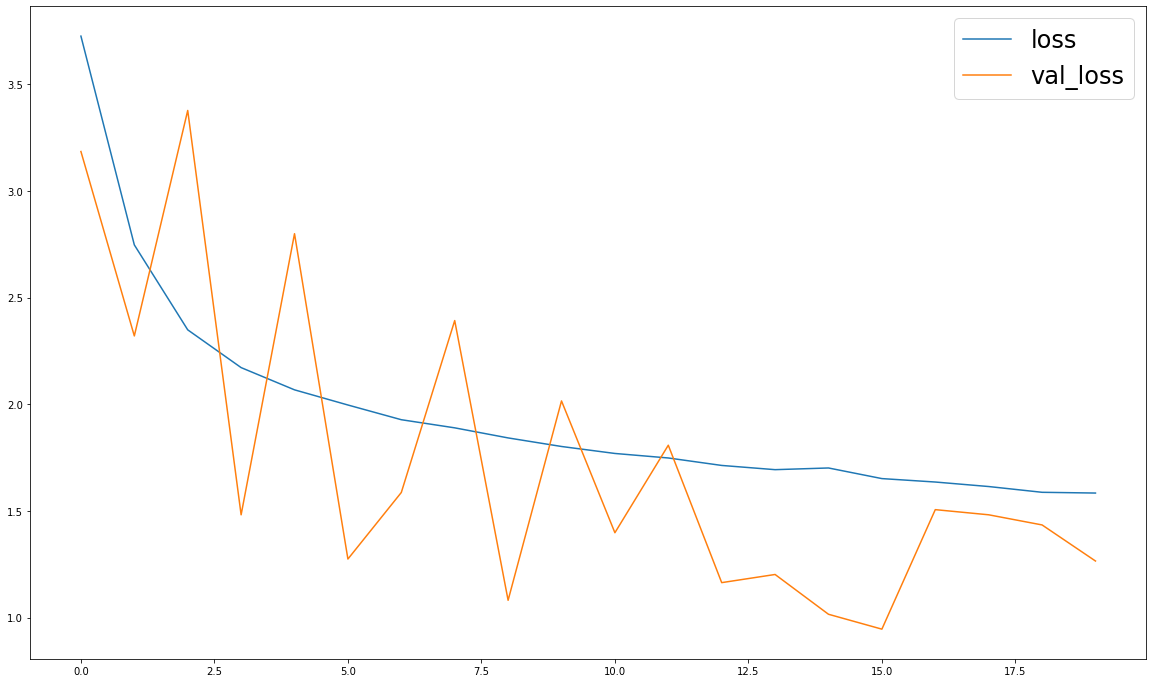

In [134]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

## Make predictions on the validation dataset

In [145]:
# Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)
# Generate samples

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: udacity_driving_datasets/1478899740253403319.jpg

Ground truth boxes:

[[  1  75 153 151 204]
 [  1 184 153 198 163]
 [  1 228 151 262 179]
 [  1 246 140 372 233]]


In [146]:
# Make a prediction

y_pred = model.predict(batch_images)

Note: the model outputs raw predictions that still need to be decoded and filtered

decode_detections() procedure:

1) In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions (to filter out the majority of the predicted boxes).

2) greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left.

3) the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. 



In [147]:
# Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.99 249.57 132.73 389.42 232.43]
 [  1.     0.99  59.58 155.93 150.71 209.  ]
 [  1.     0.9  227.13 149.23 258.08 178.24]
 [  1.     0.77  50.19 158.19  88.33 188.84]]


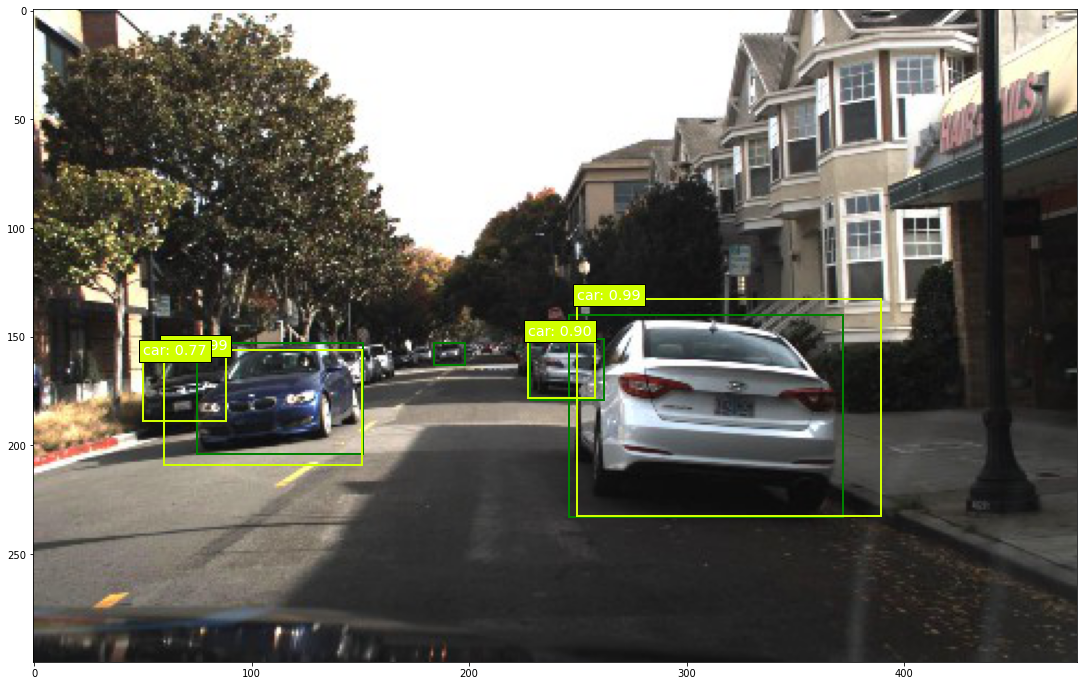

In [148]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

#**Section 2 : Calculate the mean average percentage (mAP)**

In [149]:
%tensorflow_version 1.x
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

#from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation


#Height, width, channels of the input images
img_height = 300 
img_width = 480 
img_channels = 3 
model_mode = 'inference'
# The current settings to transform the input pixel values to the interval `[-1,1]`.
intensity_mean = 127.5 
intensity_range = 127.5 

# Number of classes in the uploaded dataset
n_classes = 5 

# An explicit list of anchor box scaling factors. If this is passed, 
# it will override the `min_scale` and `max_scale` arguments.
scales = [0.08, 0.16, 0.32, 0.64, 0.96]

aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True #generate two anchor boxes for aspect ratio 1
steps = None # to set the step sizes for the anchor box grids manually; none to set it automaitcally
offsets = None # to set the offsets for the anchor box grids manually;
clip_boxes = False # this option to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # the model is supposed to use coordinates relative to the image size



In [150]:

# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7ResNet_epoch-16_loss-1.6517_val_loss-0.9458.h5' #'ssd7ResNet_epoch-20_loss-2.0425_val_loss-1.5848.h5'

# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    mode=model_mode,
                    n_classes=n_classes,
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

model.load_weights(model_path, by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Create a data generator for the evaluation dataset

In [ ]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.
# DataGenerator provides loading the entire dataset into memory, 
# which reduces the access time for any image
# Another option is loading the HDF5 file that stores the images as uncompressed arrays in a contiguous block of memory, 
# which dramatically speeds up the loading time.

# if we go for calculating the mAP so we can comment out loading the train dataset to save ram memory

##train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_train.h5')
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path='dataset_traffic_val.h5')

# 2: Parse the image and label lists for the training and validation datasets.

# Images
images_dir = 'udacity_driving_datasets'

# Ground truth
##train_labels_filename = 'labels_train.csv'
val_labels_filename   = 'labels_val.csv'

##train_dataset.parse_csv(images_dir=images_dir,
##                        labels_filename=train_labels_filename,
##                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
##                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that cas the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_traffic_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_traffic_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

# Get the number of samples in the training and validations datasets.
##train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

##print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading image IDs: 100%|██████████| 4241/4241 [00:00<00:00, 6028.44it/s]
Number of images in the validation dataset:	  4241


In [151]:
from eval_utils.average_precision_evaluator import Evaluator
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 4241

Matching predictions to ground truth, class 5/5.: 100%|██████████| 466474/466474 [00:17<00:00, 26547.11it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


In [152]:
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

car           AP    0.495
truck         AP    0.328
pedestrian    AP    0.108
bicyclist     AP    0.029
light         AP    0.05

              mAP   0.202
